# 

# Capstone Project - Women's Clothing Sentiment Analysis

## With Combined TF-IDF Vectors as features and Text/NLP

### Import libraries

In [75]:
## Import Libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import string
import spacy
import regex as re
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob

from collections import Counter

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from mlxtend.classifier import StackingClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import RFECV
from sklearn import model_selection
from sklearn.model_selection import cross_val_score

from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
# import warnings
# warnings.filterwarnings('ignore')

import joblib

%matplotlib inline

#### Load data

In [2]:
# Loading the data
df = pd.read_csv('./Data/Womens Clothing E-Commerce Reviews.csv')
df.head()


,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Intimates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [3]:
df.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Intimates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


## EDA

#### Inspect the data

- Check for
    - **Number of features**
    - **Data types**
    - **Domains, Intervals**
    - **Outliers** (are they valid or expurious data [read or measure errors])
  
    - **Missing Values** (coded [as zero of empty strings] or values not present)
    - **Coded content** (classes identified by numbers or codes to represent absence of data)


In [4]:
df.shape

(23486, 11)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Unnamed: 0               23486 non-null  int64 
 1   Clothing ID              23486 non-null  int64 
 2   Age                      23486 non-null  int64 
 3   Title                    19676 non-null  object
 4   Review Text              22641 non-null  object
 5   Rating                   23486 non-null  int64 
 6   Recommended IND          23486 non-null  int64 
 7   Positive Feedback Count  23486 non-null  int64 
 8   Division Name            23472 non-null  object
 9   Department Name          23472 non-null  object
 10  Class Name               23472 non-null  object
dtypes: int64(6), object(5)
memory usage: 2.0+ MB


###### Check for **Null** values 

In [6]:
df.isnull().sum()

Unnamed: 0                    0
Clothing ID                   0
Age                           0
Title                      3810
Review Text                 845
Rating                        0
Recommended IND               0
Positive Feedback Count       0
Division Name                14
Department Name              14
Class Name                   14
dtype: int64

###### Drop  null values and Drop Column Unnamed as it has no value in Analysis

In [7]:
df = df.dropna()

In [8]:
df=df.drop(['Unnamed: 0'], axis = 1)

In [9]:
df = df.reset_index(drop=True)

##### Creating a Target Column

In [10]:
# Select Data for Sentiment Analysis
df['Sentiment'] = df['Rating'].replace([1,2,3,4,5],[-1,-1,0,1,1])   
df=df.drop(['Rating'], axis = 1)
df = df.reset_index(drop=True)

In [11]:
df.head()

,Clothing ID,Age,Title,Review Text,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Sentiment
0,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,0,0,General,Dresses,Dresses,0
1,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",1,0,General Petite,Bottoms,Pants,1
2,847,47,Flattering shirt,This shirt is very flattering to all due to th...,1,6,General,Tops,Blouses,1
3,1080,49,Not for the very petite,"I love tracy reese dresses, but this one is no...",0,4,General,Dresses,Dresses,-1
4,858,39,Cagrcoal shimmer fun,I aded this in my basket at hte last mintue to...,1,1,General Petite,Tops,Knits,1


###### Check for **Zero** values 

In [12]:
df.isin([0]).sum()

Clothing ID                   0
Age                           0
Title                         0
Review Text                   0
Recommended IND            3575
Positive Feedback Count    8930
Division Name                 0
Department Name               0
Class Name                    0
Sentiment                  2464
dtype: int64

In [13]:
# Both features can have zero values

In [14]:
df.describe()

,Clothing ID,Age,Recommended IND,Positive Feedback Count,Sentiment
count,19662.000000,19662.000000,19662.000000,19662.000000,19662.000000
mean,921.297274,43.260808,0.818177,2.652477,0.666056
std,200.227528,12.258122,0.385708,5.834285,0.656561
min,1.000000,18.000000,0.000000,0.000000,-1.000000
25%,861.000000,34.000000,1.000000,0.000000,1.000000
50%,936.000000,41.000000,1.000000,1.000000,1.000000
75%,1078.000000,52.000000,1.000000,3.000000,1.000000
max,1205.000000,99.000000,1.000000,122.000000,1.000000


In [15]:
# Age group is between 18 - 99 with median age of 41 and mean age of 43. Positive feedback count varies between 0-122.

<AxesSubplot:>

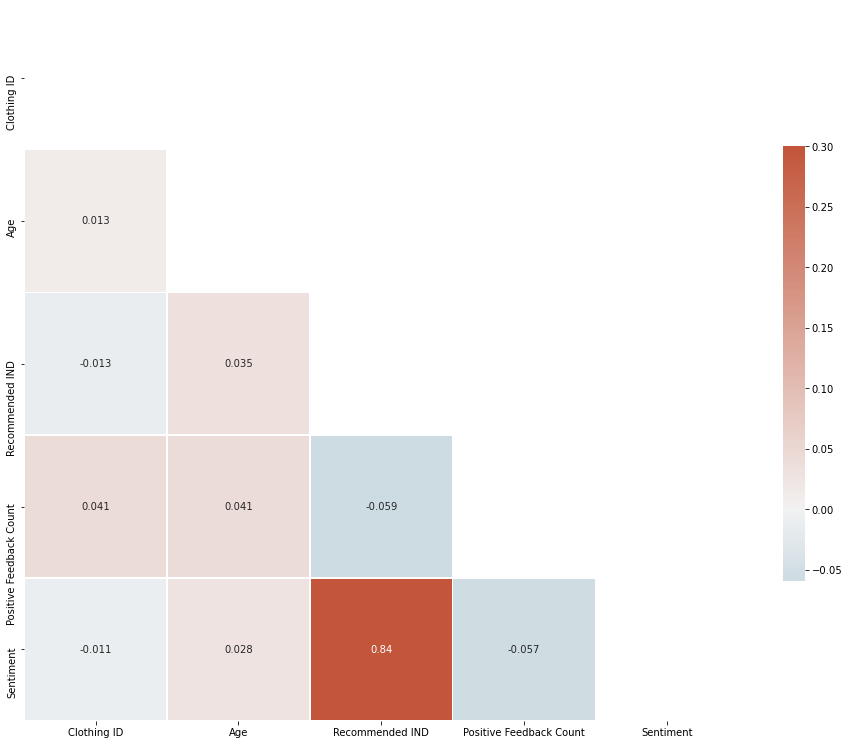

In [16]:
# correlation heatmap
plt.figure(figsize=(16, 16))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(df.corr(), dtype=bool))
sns.heatmap(df.corr(), annot=True, mask=mask, cmap=cmap,vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

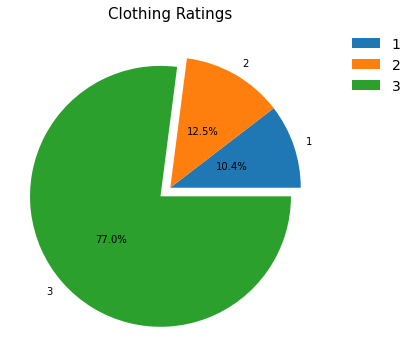

In [17]:
att=df.groupby("Sentiment")['Sentiment'].count()
pie, ax = plt.subplots(figsize=[10,6])
labels = '1','2','3'
my_explode = (0,0,0.1)
plt.pie(x=att, autopct="%.1f%%", explode=my_explode,labels=labels, pctdistance=0.5)
plt.title("Clothing Ratings", fontsize=15);
ax.legend(frameon=False, bbox_to_anchor=(1.02, 1),fontsize=14)

In [18]:
df.isnull().sum()

Clothing ID                0
Age                        0
Title                      0
Review Text                0
Recommended IND            0
Positive Feedback Count    0
Division Name              0
Department Name            0
Class Name                 0
Sentiment                  0
dtype: int64

In [19]:
df.shape

(19662, 10)

In [20]:
# Combined  Text Features
df['Review Text New'] = df['Review Text'] + df['Title']

###### Data Cleaning for Analysis

###### Step 1 - Clean text

In [21]:
def clean_text(text):
    
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)

    # remove double quotes
    text = re.sub(r'"', '', text)
    # remove special characters, numbers, punctuations
    text = re.sub(r'[^a-zA-Z#]', ' ', text)
    # remove single characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ' , text)
    # reduce multiple spaces and newlines to only one
    text = re.sub(r'(\s\s+|\n\n+)', r'\1', text)

    return text

In [22]:
# Clean Data
df['Review Text New'] = df['Review Text New'].apply(clean_text)

In [23]:
df[['Review Text New']].head(10)

,Review Text New
0,I had such high hopes for this dress and reall...
1,I love love love this jumpsuit it fun fli...
2,This shirt is very flattering to all due to th...
3,I love tracy reese dresses but this one is no...
4,I aded this in my basket at hte last mintue to...
5,I ordered this in carbon for store pick up an...
6,I love this dress usually get an xs but it run...
7,I and lbs ordered the petite to make sure ...
8,Dress runs small esp where the zipper area run...
9,More and more find myself reliant on the revie...


###### Step 2 - Remove stop words, puctuations and  perform lemmatization

In [24]:
nlp = spacy.load('en_core_web_sm')

In [25]:
# remove stop words, puctuations and  perform lemmatization
def convert_text(text):
    '''
   Remove StopWords, Punctuation and Lemmatize.
    '''
    doc = nlp(text)
    t = [w for w in doc if not (w.is_stop | w.is_punct)]
    x = [w.lemma_.lower() for w in t]

    s= " ".join(x)

    return s

In [26]:
%%time
df['Review Text New'] = df['Review Text New'].apply(convert_text)

Wall time: 3min 7s


In [27]:
df[['Review Text New']].head(5)

,Review Text New
0,high hope dress want work initially order peti...
1,love love love jumpsuit fun flirty ...
2,shirt flattering adjustable tie perfect leng...
3,love tracy reese dress petite foot tall u...
4,ade basket hte mintue look like person stor...


## Feature Engineering

#### Add Polarity as feature using TextBlob Library

In [28]:
df['Polarity'] = df['Review Text New'].apply(lambda x: TextBlob(x).sentiment.polarity)

#### Text / NLP based features

Create some other features.

Char_Count = Number of Characters in Text

Word_Count = Number of Words in Text

Sentence Count = Number of Sentences in Text

Average Word Length = Average Number of Char in Words

Average Sentence Length =  Average Sentence Length

In [29]:
%%time
# New Features

df['char count'] = df['Review Text New'].apply(len)
df['word count'] = df['Review Text New'].apply(lambda x: len(x.split()))
df['avg word lenth'] = df['char count'] / (df['word count']+1)
df['avg sentence lenght'] = df['word count'] / (df['Review Text New'].apply(lambda x: len(str(x).split("."))))


Wall time: 62.1 ms


#### POS based Features

In [30]:
def count_num(text):
    
    doc = nlp(text)
    count = 0
    for w in doc:
        if w.pos_ == "NOUN":
            count+=1
            
    return count

def adj_count(text):
    
    doc = nlp(text)
    count = 0
    for w in doc:
        if w.pos_ == "ADJ":
            count+=1
            
    return count

def adv_count(text):
    
    doc = nlp(text)
    count = 0
    for w in doc:
        if w.pos_ == "ADV":
            count+=1
            
    return count

def propn_count(text):
    
    doc = nlp(text)
    count = 0
    for w in doc:
        if w.pos_ == "PRON":
            count+=1
            
    return count

def num_count(text):
    
    doc = nlp(text)
    count = 0
    for w in doc:
        if w.pos_ == "NUM":
            count+=1
            
    return count



In [31]:
# Adding new features (pos)
df['noun_count'] = df['Review Text New'].apply(count_num)
df['adj_count'] = df['Review Text New'].apply(adj_count)
df['adv_count'] = df['Review Text New'].apply(adv_count)
df['num_count'] = df['Review Text New'].apply(num_count)

In [32]:
df.head()

,Clothing ID,Age,Title,Review Text,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Sentiment,Review Text New,Polarity,char count,word count,avg word lenth,avg sentence lenght,noun_count,adj_count,adv_count,num_count
0,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,0,0,General,Dresses,Dresses,0,high hope dress want work initially order peti...,0.030163,306,46,6.510638,46.0,16,13,6,0
1,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",1,0,General Petite,Bottoms,Pants,1,love love love jumpsuit fun flirty ...,0.500000,97,13,6.928571,13.0,5,4,0,0
2,847,47,Flattering shirt,This shirt is very flattering to all due to th...,1,6,General,Tops,Blouses,1,shirt flattering adjustable tie perfect leng...,0.750000,119,15,7.437500,15.0,9,4,0,0
3,1080,49,Not for the very petite,"I love tracy reese dresses, but this one is no...",0,4,General,Dresses,Dresses,-1,love tracy reese dress petite foot tall u...,0.056250,251,37,6.605263,37.0,21,7,4,0
4,858,39,Cagrcoal shimmer fun,I aded this in my basket at hte last mintue to...,1,1,General Petite,Tops,Knits,1,ade basket hte mintue look like person stor...,0.150625,298,45,6.478261,45.0,14,4,1,0


In [33]:
features = ['Polarity','char count','word count','avg word lenth','avg sentence lenght','noun_count','adj_count','adv_count','num_count']

<AxesSubplot:>

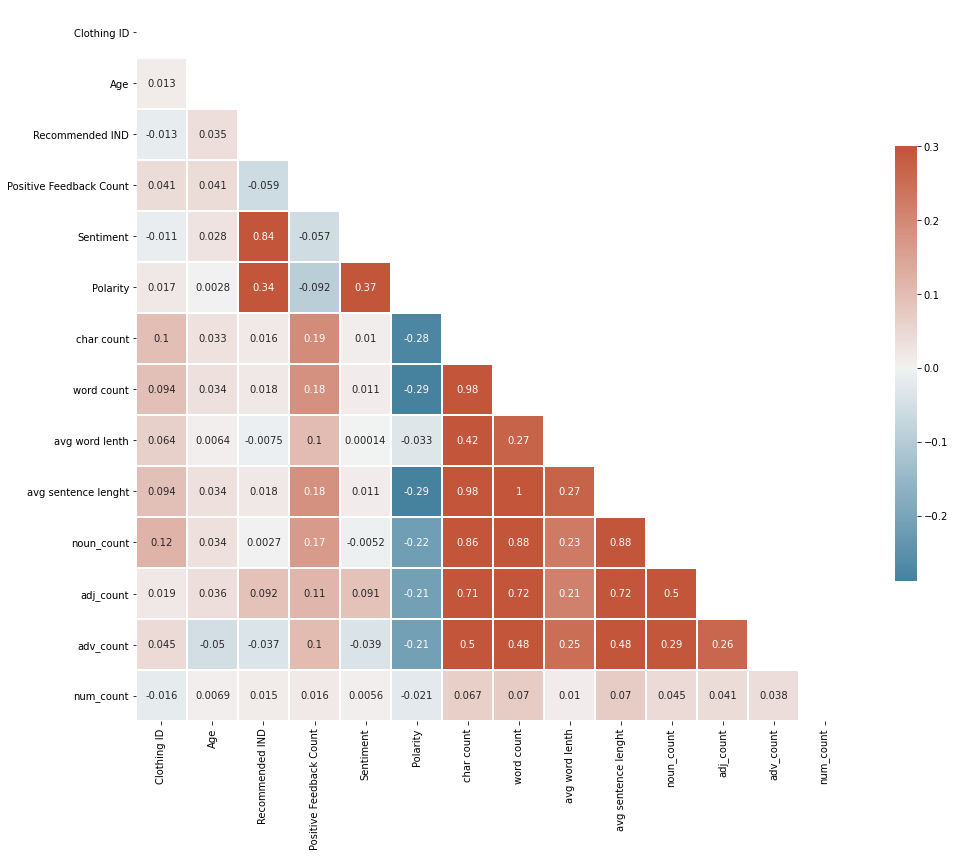

In [34]:
 # correlation heatmap
plt.figure(figsize=(16, 16))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(df.corr(), dtype=bool))
sns.heatmap(df.corr(), annot=True, mask=mask, cmap=cmap,vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### TF-IDF Vectors as features

In [35]:
%%time
# word level tf-idf for Review Text
tfidf_vect = TfidfVectorizer(analyzer = 'word',
                             token_pattern = r'\w{1,}',
                             max_features = 500)
tfidf=tfidf_vect.fit_transform(df['Review Text New']).toarray()
text_vect = pd.DataFrame(tfidf)

Wall time: 384 ms


In [36]:
X = pd.merge(text_vect,df[features],left_index=True, right_index=True)
y1 = df['Sentiment']
y2 = df['Recommended IND']
X

,0,1,2,3,4,5,6,7,8,9,...,499,Polarity,char count,word count,avg word lenth,avg sentence lenght,noun_count,adj_count,adv_count,num_count
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.175432,0.030163,306,46,6.510638,46.0,16,13,6,0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.500000,97,13,6.928571,13.0,5,4,0,0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.750000,119,15,7.437500,15.0,9,4,0,0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.056250,251,37,6.605263,37.0,21,7,4,0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.150625,298,45,6.478261,45.0,14,4,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19657,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.708333,90,14,6.000000,14.0,5,4,1,0
19658,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.191667,167,23,6.958333,23.0,6,6,2,0
19659,0.421319,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.450000,83,12,6.384615,12.0,3,6,1,0
19660,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.495455,253,37,6.657895,37.0,13,9,2,0


In [37]:
X.shape

(19662, 509)

#### Balance dataset

In [38]:
# # import library
from imblearn.over_sampling import SMOTE

smote = SMOTE()

# fit predictor and target variable
X_smote1, y_smote1 = smote.fit_resample(X, y1)
X_smote2, y_smote2 = smote.fit_resample(X, y2)


In [39]:
print('Original dataset shape', Counter(y1))
print('Resample dataset shape', Counter(y_smote1))

Original dataset shape Counter({1: 15147, 0: 2464, -1: 2051})
Resample dataset shape Counter({0: 15147, 1: 15147, -1: 15147})


In [40]:
print('Original dataset shape', Counter(y2))
print('Resample dataset shape', Counter(y_smote2))

Original dataset shape Counter({1: 16087, 0: 3575})
Resample dataset shape Counter({0: 16087, 1: 16087})


## Split the data into train and test

In [41]:
# split the dataset for Sentiment Classification
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_smote1, y_smote1, test_size = 0.2, random_state = 42)

# Split the dataset for Recommendation classification

X_train2, X_test2, y_train2, y_test2 = train_test_split(X_smote2, y_smote2, test_size = 0.2, random_state = 42)

## Modelling

In [42]:
# Model evaluation function
def evaluate_model_Rating(classifier, feature_vector_train, label_train, feature_vector_test,label_test):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label_train)

    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_test)
    
    # predict accuracy
    print(f" Accuracy Score for train data = {classifier.score(feature_vector_train, label_train)}")
    print(f" Accuracy Score for test data = {classifier.score(feature_vector_test, label_test)}")
    
    
    # confusion matrix
    log_cm = metrics.confusion_matrix(label_test, predictions,[-1,0,1])
    sns.heatmap(log_cm, annot=True, fmt='.2f',xticklabels = ['Negative','Neutral','Positive'] , yticklabels = ['Negative','Neutral','Positive'],cmap='Blues' )
    plt.title('Confusion Matrics')
    plt.savefig('cm')
    
   
    # Classification Report for test data
    print("Classification Report for test data")
    print(classification_report(label_test, predictions))
    
    return classifier.score(feature_vector_test, label_test)

In [43]:
# Model evaluation function
def evaluate_model_Recommondation(classifier, feature_vector_train, label_train, feature_vector_test,label_test):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label_train)

    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_test)
    
    # predict accuracy
    print(f" Accuracy Score for train data = {classifier.score(feature_vector_train, label_train)}")
    print(f" Accuracy Score for test data = {classifier.score(feature_vector_test, label_test)}")
    
    
    # confusion matrix
    log_cm = metrics.confusion_matrix(label_test, predictions,[0,1])
    sns.heatmap(log_cm, annot=True, fmt='.2f',xticklabels = ['Not-Recommended','Recommended'] , yticklabels = ['Not-Recommended','Recommended'],cmap='Blues' )
    plt.title('Confusion Matrics')
    plt.savefig('cm')
    
   
    # Classification Report for test data
    print("Classification Report for test data")
    print(classification_report(label_test, predictions))
    
    return classifier.score(feature_vector_test, label_test)

In [44]:
# Keep the results in a dataframe
results_Rating = pd.DataFrame(columns = ['WordLevel TF-IDF'])
results_Recommendation = pd.DataFrame(columns = ['WordLevel TF-IDF'])

### Linear Classifier

#### Sentiment Classification

 Accuracy Score for train data = 0.7661201584507042
 Accuracy Score for test data = 0.761359885575971
Classification Report for test data


C:\Users\SULAKKHANA\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=[-1, 0, 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


              precision    recall  f1-score   support

          -1       0.73      0.75      0.74      3036
           0       0.69      0.63      0.66      3036
           1       0.86      0.90      0.88      3017

    accuracy                           0.76      9089
   macro avg       0.76      0.76      0.76      9089
weighted avg       0.76      0.76      0.76      9089

Wall time: 4.24 s


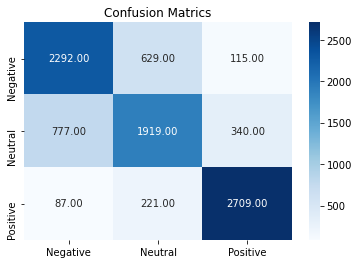

In [45]:
%%time
accuracy1 = evaluate_model_Rating(LogisticRegression(solver='liblinear'), X_train1, y_train1,X_test1 , y_test1)

In [46]:
results_Rating.loc['Logistic Regression'] ={'WordLevel TF-IDF': accuracy1}

#### Recommendation Classification

 Accuracy Score for train data = 0.9116127277672015
 Accuracy Score for test data = 0.9075369075369075
Classification Report for test data
              precision    recall  f1-score   support

           0       0.91      0.91      0.91      3217
           1       0.91      0.91      0.91      3218

    accuracy                           0.91      6435
   macro avg       0.91      0.91      0.91      6435
weighted avg       0.91      0.91      0.91      6435

Wall time: 785 ms


C:\Users\SULAKKHANA\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=[0, 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


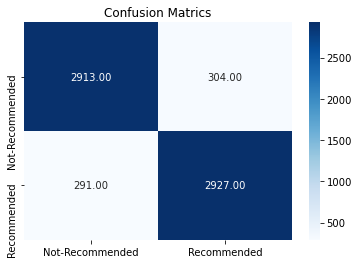

In [47]:
%%time
accuracy2 = evaluate_model_Recommondation(LogisticRegression(solver='liblinear'), X_train2, y_train2,X_test2 , y_test2)


In [48]:
results_Recommendation.loc['Logistic Regression'] ={'WordLevel TF-IDF': accuracy2}

### Naive Bayes Classifier

#### Sentiment Classification

 Accuracy Score for train data = 0.6765514964788732
 Accuracy Score for test data = 0.6709208933876114


C:\Users\SULAKKHANA\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=[-1, 0, 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Classification Report for test data
              precision    recall  f1-score   support

          -1       0.61      0.75      0.67      3036
           0       0.60      0.49      0.54      3036
           1       0.82      0.77      0.80      3017

    accuracy                           0.67      9089
   macro avg       0.67      0.67      0.67      9089
weighted avg       0.67      0.67      0.67      9089

Wall time: 1.45 s


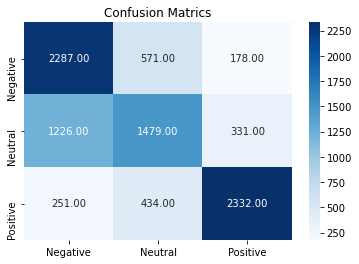

In [49]:
%%time
# Naive Bayes on word Level TF IDF Vectors
accuracy1 = evaluate_model_Rating(GaussianNB(), X_train1, y_train1,X_test1,y_test1)

In [50]:
results_Rating.loc['Naive Bayes'] = {'WordLevel TF-IDF': accuracy1}

#### Recommendation Classification

 Accuracy Score for train data = 0.8464975329266872
 Accuracy Score for test data = 0.8456876456876457
Classification Report for test data


C:\Users\SULAKKHANA\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=[0, 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


              precision    recall  f1-score   support

           0       0.82      0.88      0.85      3217
           1       0.87      0.81      0.84      3218

    accuracy                           0.85      6435
   macro avg       0.85      0.85      0.85      6435
weighted avg       0.85      0.85      0.85      6435

Wall time: 777 ms


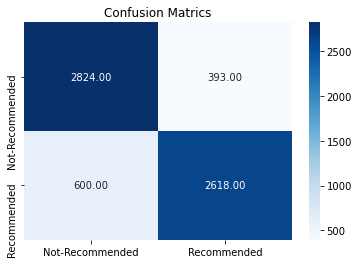

In [51]:
%%time
# Naive Bayes on word Level TF IDF Vectors
accuracy2 = evaluate_model_Recommondation(GaussianNB(), X_train2, y_train2,X_test2,y_test2)

In [52]:
results_Recommendation.loc['Naive Bayes'] = {'WordLevel TF-IDF': accuracy2}

### Bagging Models

#### Sentiment Classification

 Accuracy Score for train data = 1.0
 Accuracy Score for test data = 0.9559907580591924
Classification Report for test data
              precision    recall  f1-score   support

          -1       0.97      0.96      0.97      3036
           0       0.96      0.94      0.95      3036
           1       0.94      0.96      0.95      3017

    accuracy                           0.96      9089
   macro avg       0.96      0.96      0.96      9089
weighted avg       0.96      0.96      0.96      9089



C:\Users\SULAKKHANA\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=[-1, 0, 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Wall time: 22.7 s


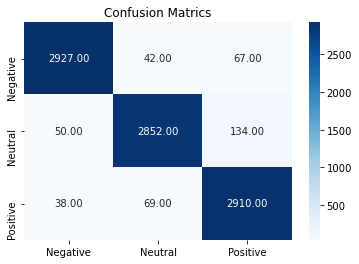

In [53]:
%%time
accuracy1 = evaluate_model_Rating(RandomForestClassifier(), X_train1, y_train1,X_test1 , y_test1)

In [54]:
results_Rating.loc['Random Forest'] = {'WordLevel TF-IDF': accuracy1}

In [55]:
param_grid = {
    'max_depth': [70,80,100],
    'min_samples_leaf': [1,3, 4],
    'min_samples_split': [2,3,8],
    'n_estimators': [10,50, 100,150,200]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the random search model
grid_search = RandomizedSearchCV(estimator = rf, param_distributions = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2)
best_model = grid_search.fit(X_train1,y_train1)
grid_search.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


{'n_estimators': 200,
 'min_samples_split': 3,
 'min_samples_leaf': 1,
 'max_depth': 80}

 Accuracy Score for train data = 1.0
 Accuracy Score for test data = 0.9563208273737485
Classification Report for test data
              precision    recall  f1-score   support

          -1       0.98      0.96      0.97      3036
           0       0.96      0.94      0.95      3036
           1       0.93      0.97      0.95      3017

    accuracy                           0.96      9089
   macro avg       0.96      0.96      0.96      9089
weighted avg       0.96      0.96      0.96      9089



C:\Users\SULAKKHANA\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=[-1, 0, 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Wall time: 34.8 s


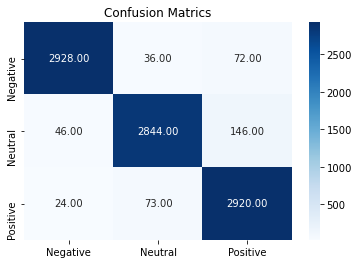

In [56]:
%%time
accuracy1 = evaluate_model_Rating(RandomForestClassifier( max_depth=100,min_samples_leaf=1,min_samples_split=3, n_estimators=150), X_train1, y_train1,X_test1 , y_test1)

#### Recommendation Classification

 Accuracy Score for train data = 1.0
 Accuracy Score for test data = 0.9393939393939394


C:\Users\SULAKKHANA\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=[0, 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Classification Report for test data
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      3217
           1       0.94      0.94      0.94      3218

    accuracy                           0.94      6435
   macro avg       0.94      0.94      0.94      6435
weighted avg       0.94      0.94      0.94      6435

Wall time: 15.1 s


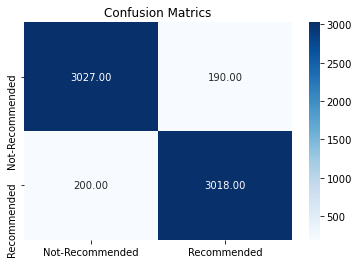

In [57]:
%%time
accuracy2 = evaluate_model_Recommondation(RandomForestClassifier(), X_train2, y_train2,X_test2 , y_test2)

In [58]:
results_Recommendation.loc['Random Forest'] = {'WordLevel TF-IDF': accuracy2}

### Boosting Models

#### Sentiment Classification

 Accuracy Score for train data = 0.8014964788732394
 Accuracy Score for test data = 0.7803938827153702


C:\Users\SULAKKHANA\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=[-1, 0, 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Classification Report for test data
              precision    recall  f1-score   support

          -1       0.74      0.75      0.74      3036
           0       0.74      0.66      0.70      3036
           1       0.86      0.93      0.89      3017

    accuracy                           0.78      9089
   macro avg       0.78      0.78      0.78      9089
weighted avg       0.78      0.78      0.78      9089

Wall time: 2min 38s


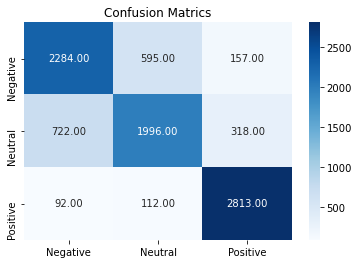

In [59]:
%%time
accuracy1 = evaluate_model_Rating(GradientBoostingClassifier(), X_train1, y_train1,X_test1 , y_test1)

In [60]:
results_Rating.loc['Gradient Boosting'] = {'WordLevel TF-IDF': accuracy1}

#### Recommendation Classification

 Accuracy Score for train data = 0.9144100392400637
 Accuracy Score for test data = 0.9098679098679099
Classification Report for test data
              precision    recall  f1-score   support

           0       0.92      0.89      0.91      3217
           1       0.90      0.93      0.91      3218

    accuracy                           0.91      6435
   macro avg       0.91      0.91      0.91      6435
weighted avg       0.91      0.91      0.91      6435



C:\Users\SULAKKHANA\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=[0, 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Wall time: 35 s


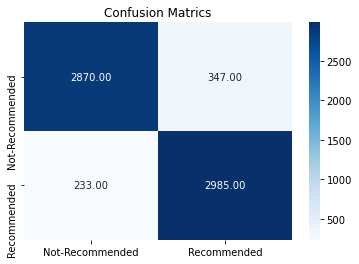

In [61]:
%%time
accuracy2 = evaluate_model_Recommondation(GradientBoostingClassifier(), X_train2, y_train2,X_test2 , y_test2)

In [62]:
results_Recommendation.loc['Gradient Boosting'] = {'WordLevel TF-IDF': accuracy2}

### Stacking

#### Sentiment Classification

C:\Users\SULAKKHANA\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


 Accuracy Score for train data = 0.9998349471830986
 Accuracy Score for test data = 0.8157112993728683
Classification Report for test data
              precision    recall  f1-score   support

          -1       0.97      0.95      0.96      3036
           0       0.66      0.97      0.79      3036
           1       0.96      0.52      0.67      3017

    accuracy                           0.82      9089
   macro avg       0.86      0.82      0.81      9089
weighted avg       0.86      0.82      0.81      9089



C:\Users\SULAKKHANA\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=[-1, 0, 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


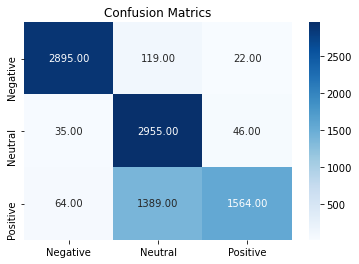

In [63]:
# create the sub models
clf1 = KNeighborsClassifier(n_neighbors = 1)
clf1.fit(X_train1, y_train1)
clf2 = RandomForestClassifier(n_estimators = 10, random_state = 1)
clf2.fit(X_train1, y_train1)
clf3 = GaussianNB()
clf3.fit(X_train1, y_train1)
lr = LogisticRegression(multi_class = 'auto', solver = 'lbfgs')
lr.fit(X_train1, y_train1)

# %%time
accuracy1 = evaluate_model_Rating(StackingClassifier(classifiers = [clf1, clf2, clf3],meta_classifier = lr), X_train1, y_train1,X_test1 , y_test1)

In [64]:
results_Rating.loc['Stacking Classifier'] = {'WordLevel TF-IDF': accuracy1}

#### Recommendation Classification

C:\Users\SULAKKHANA\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


 Accuracy Score for train data = 1.0
 Accuracy Score for test data = 0.822066822066822
Classification Report for test data
              precision    recall  f1-score   support

           0       0.75      0.97      0.85      3217
           1       0.96      0.67      0.79      3218

    accuracy                           0.82      6435
   macro avg       0.85      0.82      0.82      6435
weighted avg       0.85      0.82      0.82      6435



C:\Users\SULAKKHANA\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=[0, 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


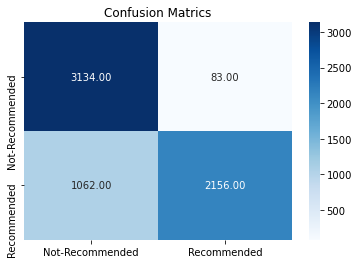

In [65]:
# create the sub models
clf1 = KNeighborsClassifier(n_neighbors = 1)
clf1.fit(X_train2, y_train2)
clf2 = RandomForestClassifier(n_estimators = 10, random_state = 1)
clf2.fit(X_train2, y_train2)
clf3 = GaussianNB()
clf3.fit(X_train2, y_train2)
lr = LogisticRegression(multi_class = 'auto', solver = 'lbfgs')
lr.fit(X_train2, y_train2)

# %%time
accuracy2 = evaluate_model_Recommondation( StackingClassifier(classifiers = [clf1, clf2, clf3],meta_classifier = lr), X_train2, y_train2,X_test2 , y_test2)

In [66]:
results_Recommendation.loc['Stacking Classifier'] = {'WordLevel TF-IDF': accuracy2}

In [67]:
results_Recommendation

,WordLevel TF-IDF
Logistic Regression,0.907537
Naive Bayes,0.845688
Random Forest,0.939394
Gradient Boosting,0.909868
Stacking Classifier,0.822067


In [68]:
results_Rating

,WordLevel TF-IDF
Logistic Regression,0.761360
Naive Bayes,0.670921
Random Forest,0.955991
Gradient Boosting,0.780394
Stacking Classifier,0.815711


In [69]:
# After considering all models we can conclude that Random Forest Classifier can use to predict the Sentiment with 93% accuracy and product recommendation with 92% accuracy.

#### Saving Trained Random Forest Model in joblib format

In [76]:
sentiment_model = RandomForestClassifier()
sentiment_model.fit(X_train1, y_train1)

joblib.dump(sentiment_model, open('sentiment_model.joblib','wb'))

In [77]:
recommendation_model = RandomForestClassifier()
recommendation_model.fit(X_train2, y_train2)

joblib.dump(recommendation_model, open('recommendation_model.joblib','wb'))